In [3]:
import numpy as np
import torch
import torch.nn as nn
import transformers
import pandas as pd
import os
import json
import sys
from src.utils import load_ECHR
from src.tokenization import tokenize_document, add_attention_masks

In [10]:
df_train = pd.read_csv('ECHR_Dataset/train.csv')
df_dev = pd.read_csv('ECHR_Dataset/dev.csv')
df_test = pd.read_csv('ECHR_Dataset/test.csv')

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7100 entries, 0 to 7099
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   ITEMID                     7100 non-null   object
 1   LANGUAGEISOCODE            7100 non-null   object
 2   RESPONDENT                 7100 non-null   object
 3   BRANCH                     7100 non-null   object
 4   DATE                       7100 non-null   int64 
 5   DOCNAME                    7100 non-null   object
 6   IMPORTANCE                 7100 non-null   int64 
 7   CONCLUSION                 7100 non-null   object
 8   JUDGES                     6383 non-null   object
 9   text                       7100 non-null   object
 10  VIOLATED_ARTICLES          7100 non-null   object
 11  VIOLATED_PARAGRAPHS        7100 non-null   object
 12  VIOLATED_BULLETPOINTS      7100 non-null   object
 13  NON_VIOLATED_ARTICLES      7100 non-null   object
 14  NON_VIOL

# Tokenization
nlpaueb/legal-

In [14]:
tokenizer = transformers.AutoTokenizer.from_pretrained('nlpaueb/legal-bert-base-uncased')
tokenizer.is_fast

True

In [15]:
import time
start = time.time()
tokenize_document(df_train['text'][0], tokenizer, max_length=512 )
end = time.time()
print('Elapsed time:', end-start)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Elapsed time: 1.5392820835113525


In [16]:
from tqdm import tqdm
tqdm.pandas()
df_train['input_ids'] = df_train['text'].progress_apply(lambda row: tokenize_document(row, tokenizer, max_length=512))

  0%|          | 31/7100 [00:17<1:05:12,  1.81it/s]


KeyboardInterrupt: 

# Analysis of the documents' length

In [9]:
#max nuubmer of sentences in a document
max_len=0
for doc in df_train['input_ids']:
    if len(doc)>max_len:
        max_len=len(doc)
max_len

102

## Histogram of the number of tokens per document

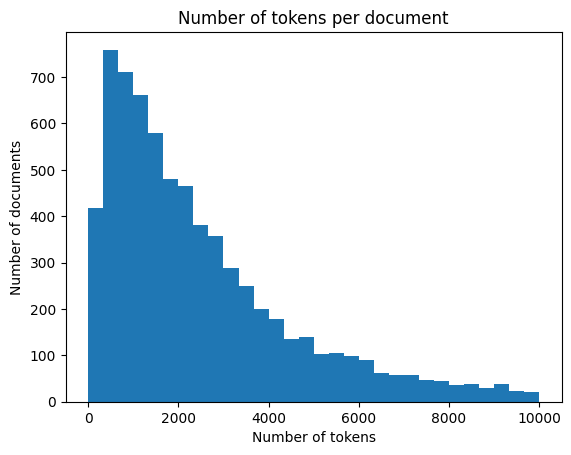

In [10]:
# histogram of number of tokens per doc
# 1 count the number of tokens in each doc
# 2 plot the histogram
#1
len_docs=[]
for doc in df_train['input_ids']:
    len_doc=0
    for sentence in doc:
        # count the non-zero elements
        len_doc+=len(sentence[sentence!=0])
    len_docs.append(len_doc)
#2
import matplotlib.pyplot as plt
len_docs=np.array(len_docs)
plt.hist(len_docs, bins=30, range=(0, 10000))
plt.title('Number of tokens per document')
plt.xlabel('Number of tokens')
plt.ylabel('Number of documents')
plt.show()



## Basic statistics

In [11]:
# basic statistics
print('Mean number of tokens per document:', np.mean(len_docs))
print('Median number of tokens per document:', np.median(len_docs))
print('Standard deviation of tokens per document:', np.std(len_docs))
print('Max number of tokens per document:', np.max(len_docs))
print('Min number of tokens per document:', np.min(len_docs))

Mean number of tokens per document: 2893.7147887323945
Median number of tokens per document: 1957.0
Standard deviation of tokens per document: 3196.2168214155317
Max number of tokens per document: 45070
Min number of tokens per document: 41


comments...

## Box plot

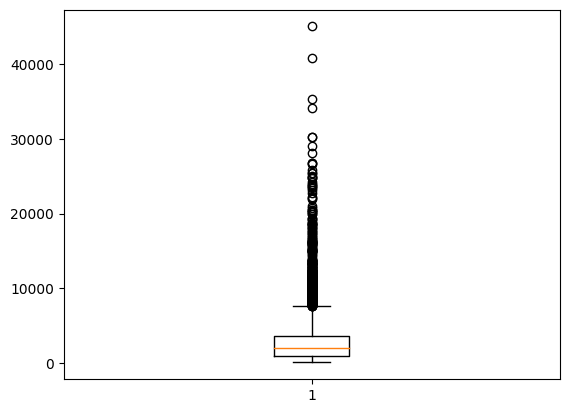

In [12]:
# box plot
plt.boxplot(len_docs)
plt.show()

# Do The same for the dev and test set

In [13]:
tqdm.pandas()
df_dev['input_ids'] = df_dev['text'].progress_apply(lambda row: tokenize_document(row, tokenizer))
df_test['input_ids'] = df_test['text'].progress_apply(lambda row: tokenize_document(row, tokenizer))

100%|██████████| 2998/2998 [00:55<00:00, 54.45it/s] 


# Add attention masks

In [14]:
df_train['attention_mask'] = df_train['input_ids'].progress_apply(lambda row: add_attention_masks(row))
df_dev['attention_mask'] = df_dev['input_ids'].progress_apply(lambda row: add_attention_masks(row))
df_test['attention_mask'] = df_test['input_ids'].progress_apply(lambda row: add_attention_masks(row))

100%|██████████| 2998/2998 [00:00<00:00, 5282.27it/s]


In [20]:
# MODEL_NAME ='legal-bert-base-uncased' # CHANGE THIS TO THE MODEL NAME

In [25]:
MODEL_NAME = input('Enter the model name: ')

In [21]:
import os
dir_name= f'../ECHR_Dataset_Tokenized/{MODEL_NAME}'
if not os.path.exists(dir_name):
    os.makedirs(dir_name)

In [22]:
os.path.exists(dir_name)

True

In [24]:
# save the tokenized datasets
df_train.to_pickle(f'../ECHR_Dataset_Tokenized/{MODEL_NAME}/df_train_tokenized.pkl')
df_dev.to_pickle(f'../ECHR_Dataset_Tokenized/{MODEL_NAME}/df_dev_tokenized.pkl')
df_test.to_pickle(f'../ECHR_Dataset_Tokenized/{MODEL_NAME}/df_test_tokenized.pkl')